# Convolution Neural Networks

Convolutional Neural Networks (CNNs) are a class of deep learning models designed specifically for processing structured grid data, such as images. They are particularly effective at recognizing patterns like edges, textures, and shapes, which makes them ideal for tasks like image classification, object detection, and segmentation.

Key components of CNNs:
- **Convolutional Layers**: Extract spatial features using filters.
- **Pooling Layers**: Reduce spatial dimensions to simplify and generalize features.
- **Fully Connected Layers**: Combine extracted features for final predictions.

CNNs leverage local connectivity and shared weights to efficiently learn hierarchical feature representations, enabling them to outperform traditional methods in many computer vision tasks.

In [1]:
import time

import numpy as np
import matplotlib.pylab as plt
import cv2 as cv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

device = "cuda"

## Data for Following Examples

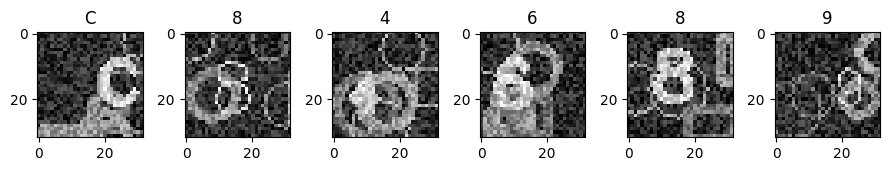

In [2]:
class DatasetArtificial(Dataset):
    
    def __init__(self, num=10, symbols="0123456789ABCDEF"):
        self.len = num
        self.cls_to_label = list(symbols)
        self.label_to_cls = {label: idx for idx, label in enumerate(self.cls_to_label)}
        self.num_classes = len(symbols)
        self.shape = (32, 32)
        self._transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        self.tensor_images = torch.empty((self.len, self.shape[0], self.shape[1]))
        self.tensor_one_hot = torch.empty((self.len, self.num_classes))
        font = cv.FONT_HERSHEY_SIMPLEX
        loc = np.random.randint((3, 19), (20, 28), (num, 2))
        font_scale = np.random.random(num) * 0.2 + 0.5
        color = 255
        thickness = np.random.randint(1, 3, num)
        np_symbols = np.array(list(symbols))
        for idx in range(num):
            name = np.random.choice(np_symbols)
            image = np.zeros(self.shape)
            self.add_random_shapes(image)
            image = cv.putText(image, str(name), loc[idx].tolist(), font, font_scale[idx], color, thickness[idx], cv.LINE_AA)
            image += np.random.randint(0, 150, image.shape)
            target = [self.label_to_cls[x] for x in name]
            one_hot = np.zeros((len(target), self.num_classes), dtype=int)
            one_hot[np.arange(len(target)), target] = 1
            self.tensor_images[idx] = self._transform(image)
            self.tensor_one_hot[idx] = torch.tensor(one_hot).float()

    def add_random_shapes(self, image):
        # Add a fixed number of random squares and circles
        num_shapes = 5  # Fixed number of shapes (squares + circles)
        
        for _ in range(num_shapes):
            shape_type = np.random.choice(['square', 'circle'])  # Randomly choose the shape type
            
            # Random color intensity higher than the background (255 is white)
            intensity = np.random.randint(100, 200)  # Intensity of the shape

            # Random location within the image
            x1 = np.random.randint(0, self.shape[1])
            y1 = np.random.randint(0, self.shape[0])

            # Define size of the shapes
            size = np.random.randint(10, 20)  # Shape size between 3 and 5 pixels

            thickness = np.random.randint(1,3)
            if shape_type == 'square':
                # Random square coordinates
                x2 = min(x1 + size, self.shape[1])  # Ensure the square fits within the image width
                y2 = min(y1 + size, self.shape[0])  # Ensure the square fits within the image height
                cv.rectangle(image, (x1, y1), (x2, y2), (intensity), thickness=thickness)  
            else:  # Draw a circle
                radius = size // 2
                cv.circle(image, (x1, y1), radius, (intensity), thickness=thickness)  

    def __len__(self):
        return self.len
        
    def __getitem__(self, idx):
        return self.tensor_images[idx].unsqueeze(0), self.tensor_one_hot[idx]

    def decode_target(self, one_hot_tensor):
        idx = torch.argmax(one_hot_tensor).tolist()
        return self.cls_to_label[idx]

dataset = DatasetArtificial(num=10)

plt.figure(figsize=(9, 3))
cols = 6
for j in range(cols):
    plt.subplot(1, cols , j + 1)
    img, target = dataset[j]
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.title(dataset.decode_target(target))
plt.tight_layout()
plt.show()

## Training and validation

In [3]:
def train_model(model, batch_size=128, num_epochs=30, lr=0.001):
    train_dataset = DatasetArtificial(num=20000)
    val_dataset = DatasetArtificial(num=1000)
    test_dataset = DatasetArtificial(num=10)
    
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9999)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses = np.zeros(num_epochs)
    val_losses = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        t0 = time.time()

        model.train()
        for train_inputs, train_targets in train_dataloader:
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            optimizer.zero_grad()
            train_outputs = model(train_inputs)
            loss = criterion(train_outputs, train_targets)
            train_losses[epoch] += loss
            
            loss.backward()
            optimizer.step()
    
        model.eval()
        total_correct = 0
        for val_inputs, val_targets in val_dataloader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_targets)
            val_losses[epoch] += loss

            correct = torch.argmax(val_targets, dim=1) == torch.argmax(val_outputs, dim=1)
            total_correct += correct.sum() 
        
    
        scheduler.step()

        elapsed_time = time.time() - t0
        if epoch % 1 == 0:    
            print(f"Epoch [{epoch+1}/{num_epochs}], Time: {elapsed_time:.2f}s, Train Loss: {train_losses[epoch]:.5f}, Validation Loss: {val_losses[epoch]:.5f}, Accuracy: {total_correct / len(val_dataset) * 100:.0f}%")

    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.legend()
    plt.xlabel("Epoch index")
    plt.ylabel("Loss [-]")
    plt.yscale('log')
    plt.show()


## Convolution Filters for Feature Extraction
Convolution is a fundamental operation in deep learning, particularly in CNNs, used to extract spatial features from data. It applies filters to input data (e.g., images) to detect patterns like edges, textures, or more complex structures, preserving spatial relationships while reducing dimensionality.

Example of 2D convolution follows:

![2d convolution](images/cnn_2d_conv.png)

Epoch [1/30], Time: 4.03s, Train Loss: 38.06308, Validation Loss: 1.87771, Accuracy: 7%
Epoch [2/30], Time: 2.42s, Train Loss: 36.06377, Validation Loss: 1.82941, Accuracy: 12%
Epoch [3/30], Time: 2.49s, Train Loss: 33.75169, Validation Loss: 1.66305, Accuracy: 25%
Epoch [4/30], Time: 2.44s, Train Loss: 30.68287, Validation Loss: 1.59109, Accuracy: 27%
Epoch [5/30], Time: 2.35s, Train Loss: 28.87427, Validation Loss: 1.54263, Accuracy: 31%
Epoch [6/30], Time: 2.37s, Train Loss: 27.06468, Validation Loss: 1.48913, Accuracy: 35%
Epoch [7/30], Time: 2.45s, Train Loss: 25.17222, Validation Loss: 1.40973, Accuracy: 37%
Epoch [8/30], Time: 2.38s, Train Loss: 23.53322, Validation Loss: 1.38721, Accuracy: 41%
Epoch [9/30], Time: 2.35s, Train Loss: 21.78017, Validation Loss: 1.35206, Accuracy: 40%
Epoch [10/30], Time: 2.36s, Train Loss: 20.20580, Validation Loss: 1.33100, Accuracy: 43%
Epoch [11/30], Time: 2.36s, Train Loss: 18.45706, Validation Loss: 1.27696, Accuracy: 47%
Epoch [12/30], Time:

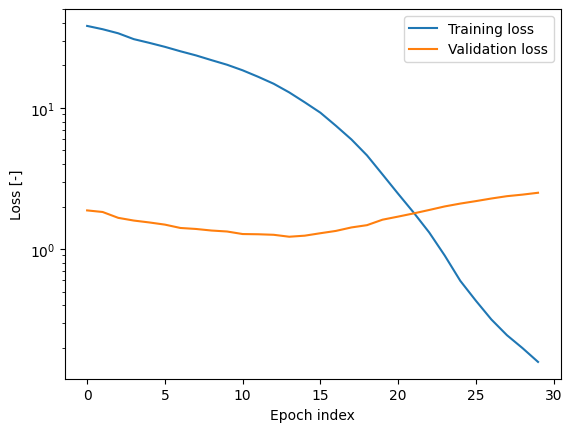

In [4]:
class DigitClassifierV1(nn.Module):

    def __init__(self, input_channels=1, num_classes=16, input_size=32):
        super(DigitClassifierV1, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self._cnn = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
        )

        self._fc = nn.Sequential(
                nn.Linear(8 * input_size * input_size, 128),  
                nn.ReLU(),   
                nn.Linear(128, num_classes),
                nn.Sigmoid()
        ) 

    def forward(self, x):
        feature_map = self._cnn(x) 
        batch_size, channels, H, W = feature_map.shape
        features = feature_map.reshape(batch_size, -1)
        predictions = self._fc(features)
        return predictions


model = DigitClassifierV1().to(device)
train_model(model)

# Adding 1x1 Convolution to Reduce the Number of Filters

A **1x1 convolution** is a convolutional layer with a filter size of 1x1. Despite its small size, it is powerful and versatile, serving several purposes:

1. **Channel-wise transformation**: It mixes information across channels without changing the spatial dimensions, acting like a fully connected layer for each pixel.
2. **Dimensionality reduction or expansion**: It reduces or increases the number of channels, making computations more efficient.
3. **Non-linear combinations**: When followed by an activation function, it enables complex feature interactions between channels.

![2d convolution](images/cnn_1x1_conv.png)

Epoch [1/30], Time: 2.17s, Train Loss: 42.39989, Validation Loss: 1.88293, Accuracy: 9%
Epoch [2/30], Time: 2.19s, Train Loss: 36.85984, Validation Loss: 1.87148, Accuracy: 8%
Epoch [3/30], Time: 2.28s, Train Loss: 36.55498, Validation Loss: 1.85158, Accuracy: 11%
Epoch [4/30], Time: 2.28s, Train Loss: 36.27079, Validation Loss: 1.83630, Accuracy: 11%
Epoch [5/30], Time: 2.30s, Train Loss: 35.90026, Validation Loss: 1.81452, Accuracy: 12%
Epoch [6/30], Time: 2.22s, Train Loss: 35.52910, Validation Loss: 1.80203, Accuracy: 14%
Epoch [7/30], Time: 2.12s, Train Loss: 35.15982, Validation Loss: 1.78856, Accuracy: 15%
Epoch [8/30], Time: 2.13s, Train Loss: 34.72425, Validation Loss: 1.76948, Accuracy: 15%
Epoch [9/30], Time: 2.21s, Train Loss: 34.21793, Validation Loss: 1.74013, Accuracy: 18%
Epoch [10/30], Time: 2.05s, Train Loss: 33.65554, Validation Loss: 1.71866, Accuracy: 19%
Epoch [11/30], Time: 2.09s, Train Loss: 33.03166, Validation Loss: 1.70699, Accuracy: 20%
Epoch [12/30], Time: 

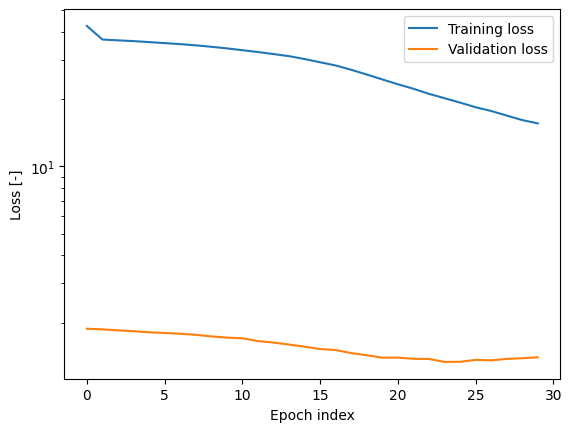

In [5]:
class DigitClassifierV2(nn.Module):
    def __init__(self, input_channels=1, num_classes=16, input_size=32):
        super(DigitClassifierV2, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self._cnn = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=1, padding=0),
        )

        self._fc = nn.Sequential(
                nn.Linear(input_size * input_size, 128),  
                nn.ReLU(),   
                nn.Linear(128, num_classes),
                nn.Sigmoid()
        ) 
   
    def forward(self, x):
        feature_map = self._cnn(x) 
        batch_size, channels, H, W = feature_map.shape
        features = feature_map.reshape(batch_size, -1)
        predictions = self._fc(features)
        return predictions


model = DigitClassifierV2().to(device)
train_model(model)

## Number of parameters inspection

In [6]:
# Input parameters: 3 channels (e.g., RGB), width 32, height 32
in_channels = 3
out_channels_1x1 = 1
out_channels_3x3 = 1
height = 3
width = 3

# Creating a Conv2d layer with a 1x1 filter
conv1x1 = nn.Conv2d(in_channels, out_channels_1x1, kernel_size=1)

# Creating a Conv2d layer with a 3x3 filter
conv3x3 = nn.Conv2d(in_channels, out_channels_3x3, kernel_size=3)

# Function to get the number of parameters
def count_parameters(layer):
    return sum(p.numel() for p in layer.parameters())

# Calculating the number of parameters for each layer
params_1x1 = count_parameters(conv1x1)
params_3x3 = count_parameters(conv3x3)

# Output the number of parameters
print(f'Number of parameters for Conv2d 1x1: {params_1x1}')
print(f'Number of parameters for Conv2d 3x3: {params_3x3}')

Number of parameters for Conv2d 1x1: 4
Number of parameters for Conv2d 3x3: 28


## Pooling

**Pooling** is an operation in CNNs used to reduce the spatial dimensions of feature maps. It simplifies the representation while retaining important information, making computations more efficient. 

Common types of pooling:

1. **Max Pooling**: Retains the maximum value from each region, emphasizing the most prominent features.
2. **Average Pooling**: Calculates the average value from each region, providing a smoother representation.

Pooling helps with:
- Reducing the number of parameters and computations.
- Making the model invariant to small translations or distortions in the input.
- Preventing overfitting by summarizing feature information.

![2d convolution](images/cnn_pooling.png)

Epoch [1/30], Time: 0.77s, Train Loss: 39.68340, Validation Loss: 1.87076, Accuracy: 9%
Epoch [2/30], Time: 0.68s, Train Loss: 36.22824, Validation Loss: 1.83151, Accuracy: 13%
Epoch [3/30], Time: 0.67s, Train Loss: 35.08023, Validation Loss: 1.76142, Accuracy: 18%
Epoch [4/30], Time: 0.68s, Train Loss: 33.44966, Validation Loss: 1.68900, Accuracy: 24%
Epoch [5/30], Time: 0.67s, Train Loss: 31.56016, Validation Loss: 1.59499, Accuracy: 29%
Epoch [6/30], Time: 0.67s, Train Loss: 29.82195, Validation Loss: 1.53717, Accuracy: 32%
Epoch [7/30], Time: 0.65s, Train Loss: 28.34443, Validation Loss: 1.48439, Accuracy: 34%
Epoch [8/30], Time: 0.64s, Train Loss: 26.89400, Validation Loss: 1.45501, Accuracy: 38%
Epoch [9/30], Time: 0.65s, Train Loss: 25.64280, Validation Loss: 1.38470, Accuracy: 41%
Epoch [10/30], Time: 0.65s, Train Loss: 24.28045, Validation Loss: 1.32140, Accuracy: 44%
Epoch [11/30], Time: 0.64s, Train Loss: 23.04093, Validation Loss: 1.31585, Accuracy: 44%
Epoch [12/30], Time:

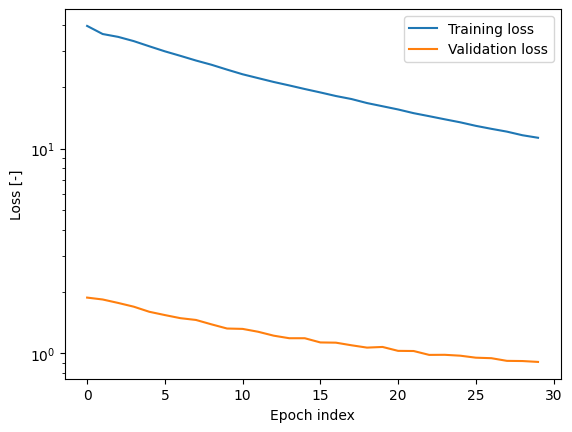

In [7]:
class DigitClassifierV3(nn.Module):
    def __init__(self, input_channels=1, num_classes=16, input_size=32):
        super(DigitClassifierV3, self).__init__()
        self.num_classes = num_classes

        self._cnn = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((16, 16)),
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((8, 8)),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((4, 4)),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self._fc = nn.Sequential(
            nn.Linear(input_size * input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        feature_map = self._cnn(x)
        batch_size, channels, H, W = feature_map.shape
        features = feature_map.view(batch_size, -1)  # Flatten the pooled feature map
        predictions = self._fc(features)
        return predictions

model = DigitClassifierV3().to(device)
train_model(model)

## Stride and dilation

**Dilation** in convolutional layers refers to the spacing between the elements of the convolutional filter, effectively expanding its receptive field without increasing the number of parameters. This allows the model to capture larger patterns or features in the input data while maintaining computational efficiency.

**Stride** in convolutional layers refers to the step size at which the filter moves across the input data. A larger stride reduces the spatial dimensions of the output, effectively downsampling the input and reducing the computational load, while a smaller stride captures finer details in the data.

Epoch [1/30], Time: 0.70s, Train Loss: 39.68469, Validation Loss: 1.88503, Accuracy: 10%
Epoch [2/30], Time: 0.61s, Train Loss: 36.53902, Validation Loss: 1.85215, Accuracy: 11%
Epoch [3/30], Time: 0.62s, Train Loss: 35.68779, Validation Loss: 1.80870, Accuracy: 15%
Epoch [4/30], Time: 0.62s, Train Loss: 34.63425, Validation Loss: 1.76983, Accuracy: 17%
Epoch [5/30], Time: 0.61s, Train Loss: 33.38277, Validation Loss: 1.68714, Accuracy: 23%
Epoch [6/30], Time: 0.62s, Train Loss: 32.08856, Validation Loss: 1.66617, Accuracy: 24%
Epoch [7/30], Time: 0.61s, Train Loss: 30.83005, Validation Loss: 1.59203, Accuracy: 30%
Epoch [8/30], Time: 0.62s, Train Loss: 29.63443, Validation Loss: 1.52778, Accuracy: 32%
Epoch [9/30], Time: 0.62s, Train Loss: 28.50843, Validation Loss: 1.50630, Accuracy: 35%
Epoch [10/30], Time: 0.61s, Train Loss: 27.57607, Validation Loss: 1.45643, Accuracy: 38%
Epoch [11/30], Time: 0.61s, Train Loss: 26.55535, Validation Loss: 1.41035, Accuracy: 40%
Epoch [12/30], Time

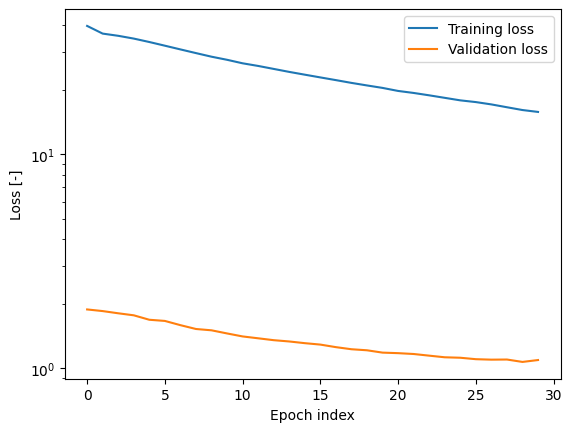

In [8]:
class DigitClassifierV4(nn.Module):
    def __init__(self, input_channels=1, num_classes=16, input_size=32):
        super(DigitClassifierV4, self).__init__()
        self.num_classes = num_classes

        self._cnn = nn.Sequential(
            nn.Conv2d(input_channels, 8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((16, 16)),
            nn.Conv2d(8, 16, kernel_size=3, padding=1, dilation=2),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((8, 8)),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool2d((4, 4)),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self._fc = nn.Sequential(
            nn.Linear(input_size * input_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        feature_map = self._cnn(x)
        batch_size, channels, H, W = feature_map.shape
        features = feature_map.view(batch_size, -1)  # Flatten the pooled feature map
        predictions = self._fc(features)
        return predictions

model = DigitClassifierV4().to(device)
train_model(model)

## Relation to Traditional Pattern Matching Approach

The following model utilizes a purely convolutional architecture without any fully connected layers. The first convolutional layer has one filter for each class, with a kernel size approximately matching the expected size of the object instances. For each channel, the maximum value is extracted using max pooling, which represents the most prominent feature detected in the corresponding region. These pooled values are then used to directly infer the likelihood of each class being present in the image.

Epoch [1/30], Time: 0.52s, Train Loss: 28.43565, Validation Loss: 0.70597, Accuracy: 76%
Epoch [2/30], Time: 0.42s, Train Loss: 10.44858, Validation Loss: 0.45790, Accuracy: 85%
Epoch [3/30], Time: 0.41s, Train Loss: 7.50892, Validation Loss: 0.36923, Accuracy: 87%
Epoch [4/30], Time: 0.41s, Train Loss: 6.31525, Validation Loss: 0.31864, Accuracy: 89%
Epoch [5/30], Time: 0.42s, Train Loss: 6.07551, Validation Loss: 0.31073, Accuracy: 90%
Epoch [6/30], Time: 0.42s, Train Loss: 5.34986, Validation Loss: 0.30997, Accuracy: 89%
Epoch [7/30], Time: 0.42s, Train Loss: 4.95577, Validation Loss: 0.30728, Accuracy: 89%
Epoch [8/30], Time: 0.42s, Train Loss: 4.66880, Validation Loss: 0.29180, Accuracy: 89%
Epoch [9/30], Time: 0.42s, Train Loss: 4.66988, Validation Loss: 0.29096, Accuracy: 90%
Epoch [10/30], Time: 0.45s, Train Loss: 4.60170, Validation Loss: 0.32293, Accuracy: 89%
Epoch [11/30], Time: 0.43s, Train Loss: 4.64743, Validation Loss: 0.35493, Accuracy: 88%
Epoch [12/30], Time: 0.43s, 

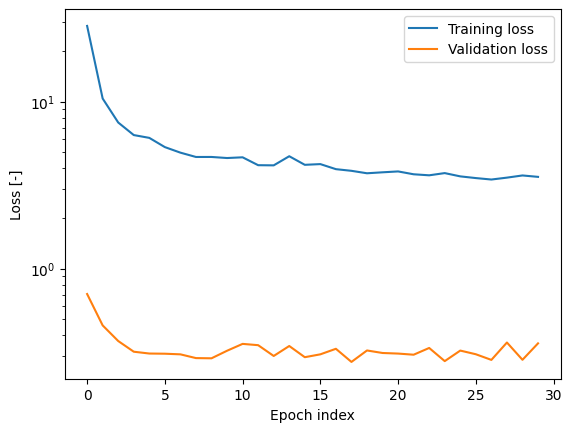

In [9]:
class DigitClassifierV0(nn.Module):

    def __init__(self, input_channels=1, num_classes=16, input_size=32):
        super(DigitClassifierV0, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self._cnn = nn.Sequential(
            nn.Conv2d(input_channels, num_classes, kernel_size=(18, 13)),
            nn.AdaptiveMaxPool2d((1, 1)),
            nn.Softmax(dim=1)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        init.zeros_(self._cnn[0].weight)  # Initialize the weights of the first Conv2d layer with zeros
        init.zeros_(self._cnn[0].bias)  # Initialize the biases of the first Conv2d layer with zeros
    
    def forward(self, x):
        predictions = self._cnn(x).squeeze(-1).squeeze(-1)
        return predictions

model = DigitClassifierV0().to(device)
train_model(model, num_epochs=30)

The patterns created by the model above can be displayed directly.

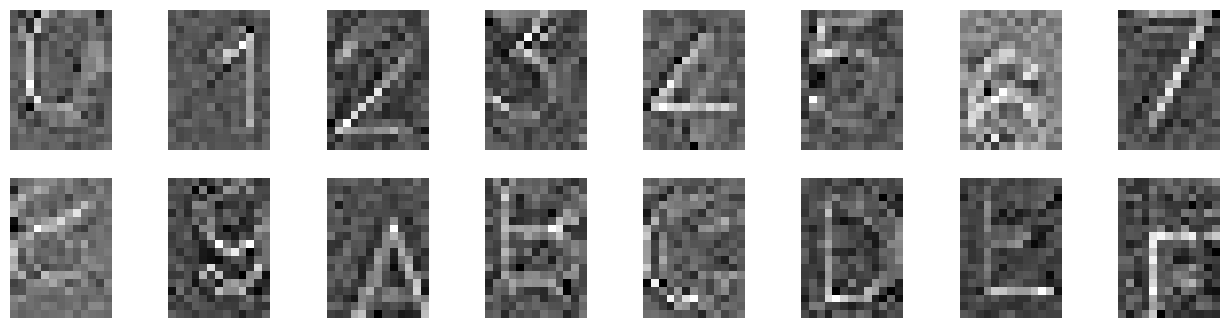

In [10]:
def plot_filters(model, num_cols=8):
    filters = model._cnn[0].weight.detach().cpu() 
    num_filters = filters.shape[0] 
    num_rows = (num_filters + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
    for i in range(num_filters):
        ax = axes[i // num_cols, i % num_cols]
        ax.imshow(filters[i, 0, :, :], cmap='gray') 
        ax.axis('off')  # Turn off axis
    plt.show()

plot_filters(model)